In [1]:
from keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
import os, random, cv2
from scipy.spatial import distance
from keras import Sequential
from keras.layers import Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB1, VGG19, ResNet50, InceptionV3, MobileNet, DenseNet201
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/SpringBoard/Sample Projects/Image Classification/face mask dataset"

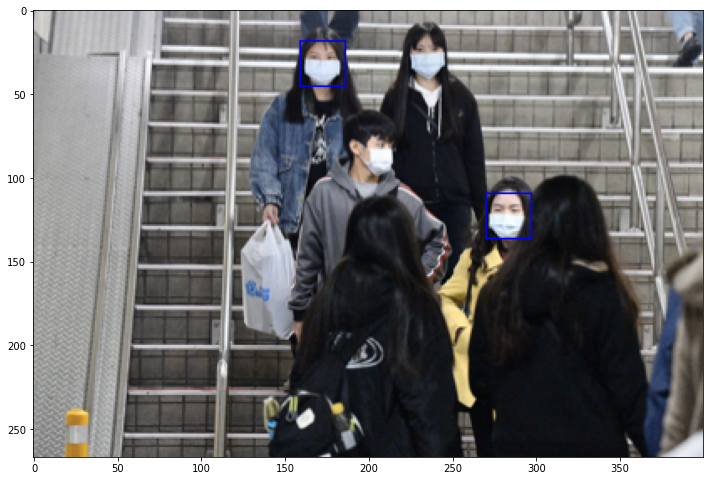

In [26]:
face_model = cv2.CascadeClassifier(path + '/haarcascade/haarcascade_frontalface_default.xml')

# Sample image
image = random.choice(os.listdir(path + '/images'))

img = cv2.imread(path+ '/images/' + image)

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

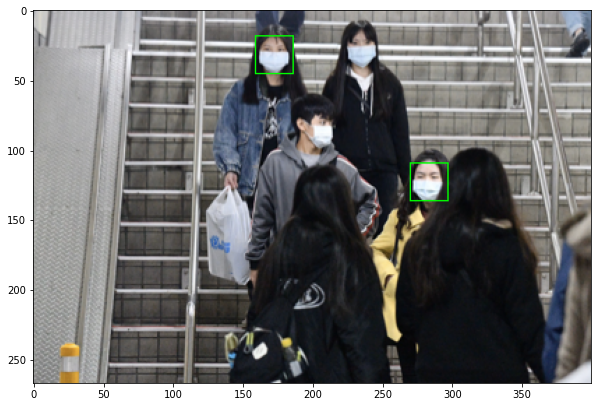

In [27]:
MIN_DISTANCE = 130

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

# VGG19

In [4]:
train_dir = path + '/12k/Train'
test_dir = path + '/12k/Test'
val_dir = path + '/12k/Validation'

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=test_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [9]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()

model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics ="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator)//32, epochs=20, validation_data=val_generator, validation_steps=len(val_generator)//32)

Epoch 1/20
9/9 [==============================] - 79s 8s/step - loss: 0.5857 - accuracy: 0.6905
Epoch 2/20
9/9 [==============================] - 69s 7s/step - loss: 0.2086 - accuracy: 0.9608
Epoch 3/20
9/9 [==============================] - 67s 7s/step - loss: 0.1297 - accuracy: 0.9629
Epoch 4/20
9/9 [==============================] - 66s 7s/step - loss: 0.1140 - accuracy: 0.9518
Epoch 5/20
9/9 [==============================] - 66s 7s/step - loss: 0.0954 - accuracy: 0.9681
Epoch 6/20
9/9 [==============================] - 65s 7s/step - loss: 0.1024 - accuracy: 0.9448
Epoch 7/20
9/9 [==============================] - 65s 7s/step - loss: 0.0724 - accuracy: 0.9815
Epoch 8/20
9/9 [==============================] - 66s 7s/step - loss: 0.0759 - accuracy: 0.9787
Epoch 9/20
9/9 [==============================] - 64s 7s/step - loss: 0.0785 - accuracy: 0.9704
Epoch 10/20
9/9 [==============================] - 65s 7s/step - loss: 0.0953 - accuracy: 0.9779
Epoch 11/20
9/9 [======================

In [12]:
# Accuracy of test data
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

31/31 [==============================] - 247s 8s/step - loss: 0.0505 - accuracy: 0.9849
Test loss: 0.05052880942821503
Test accuracy: 0.9848790168762207


In [13]:
model.save('facemask_model.h5')

In [10]:
# Accuracy and Loss Visual
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # Accuracy history
    axs[0].plot(history.history['accuracy']) 
    #axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='best')
    
    # Loss history
    axs[1].plot(history.history['loss']) 
    #axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='best')
    plt.show()

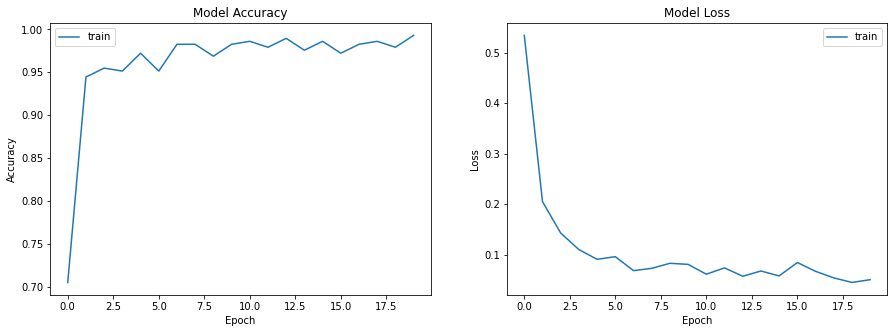

In [17]:
plotmodelhistory(history)

In [18]:
# Prediction
predictions = model.predict(test_generator)

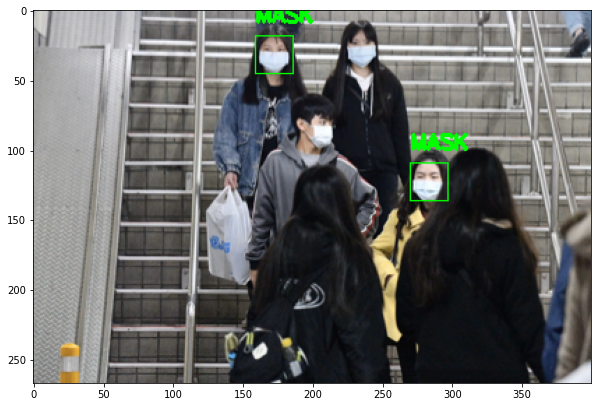

In [28]:
# Integrating Haarcascade
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

# Comparison 
- ConvNet
- InceptionV3
- MobileNet
- DenseNet
- VGG19

In [5]:
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=batch_size, class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [6]:
model_histories = []
shape = (128, 128, 3)
models = [InceptionV3(include_top=False, input_shape=shape), 
                   MobileNet(include_top=False, input_shape=shape), 
                   DenseNet201(include_top=False, input_shape=shape),
                   VGG19(include_top=False, input_shape=shape)]

names = ['ConvNet', 'InceptionV3', 'MobileNet', 'DenseNet', 'VGG19']

for layer in [Conv2D(32, (3, 3), activation='relu', input_shape=shape)]:
    model = Sequential()
    model.add(layer)
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

    model_histories.append(model.fit(train_generator, 
                                         validation_data=test_generator, 
                                         steps_per_epoch=len(train_generator)//3, 
                                         validation_steps=len(test_generator)//3, 
                                         epochs=10))

for functional in models:
    
    for layer in functional.layers:
        layer.trainable = False

    model = Sequential()
    model.add(functional)
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model_histories.append(model.fit_generator(generator=train_generator, 
                                         validation_data=test_generator, 
                        steps_per_epoch=len(train_generator)//3, 
                        validation_steps=len(test_generator)//3, epochs=10))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_94 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 254018    
Total params: 255,042
Trainable params: 254,978
Non-trainable params: 64
_________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
208/208 [==============================] - 128s 589ms/step - loss: 0.1622 - accuracy: 0.9484 - val_loss: 0.0446 - val_accuracy: 0.9844
Epoch 2/10
208/208 [==============================] - 121s 580ms/step - loss: 0.0567 - accuracy: 0.9863 - val_loss: 0.0550 - val_accuracy: 0.9906
Epoch 3/10
208/208 [==============================] - 121s 580ms/step - loss: 0.0654 - accuracy: 0.9857 - val_loss: 0.0186 - val_accuracy: 0.9937
Epoch 4/10
208/208 [==============================] - 121s 579ms/step - loss: 0.0440 - accuracy: 0.9921 - val_loss: 0.1058 - val_accuracy: 0.9906
Epoch 5/10
208/208 [==============================] - 121s 580ms/step - loss: 0.0550 - accuracy: 0.9904 - val_loss: 0.0276 - val_accuracy: 0.9906
Epoch 6/10
208/208 [==============================] - 121s 581ms/step - loss: 0.0192 - accuracy: 0.9961 - val_loss: 0.0212 - val_accuracy: 0.9937
Epoch 7/10
208/208 [==============================] - 131s 629ms/step - loss: 0.0980 - accuracy: 0.9878 - val_loss: 0.0562 -

In [7]:
import pandas as pd
for history in model_histories:
  for i in names:
    print(i)
    print(pd.DataFrame(model.history.history))

ConvNet
       loss  accuracy  val_loss  val_accuracy
0  0.160002  0.945312  0.102764      0.962500
1  0.071960  0.977163  0.031473      0.987500
2  0.046847  0.983774  0.034810      0.987500
3  0.045603  0.984375  0.044300      0.984375
4  0.040981  0.986478  0.022088      0.993750
5  0.035988  0.988882  0.019089      0.993750
6  0.026339  0.991887  0.021620      0.990625
7  0.034200  0.987981  0.017571      0.990625
8  0.031017  0.990986  0.015654      0.996875
9  0.022128  0.992488  0.024204      0.993750
InceptionV3
       loss  accuracy  val_loss  val_accuracy
0  0.160002  0.945312  0.102764      0.962500
1  0.071960  0.977163  0.031473      0.987500
2  0.046847  0.983774  0.034810      0.987500
3  0.045603  0.984375  0.044300      0.984375
4  0.040981  0.986478  0.022088      0.993750
5  0.035988  0.988882  0.019089      0.993750
6  0.026339  0.991887  0.021620      0.990625
7  0.034200  0.987981  0.017571      0.990625
8  0.031017  0.990986  0.015654      0.996875
9  0.022128  0

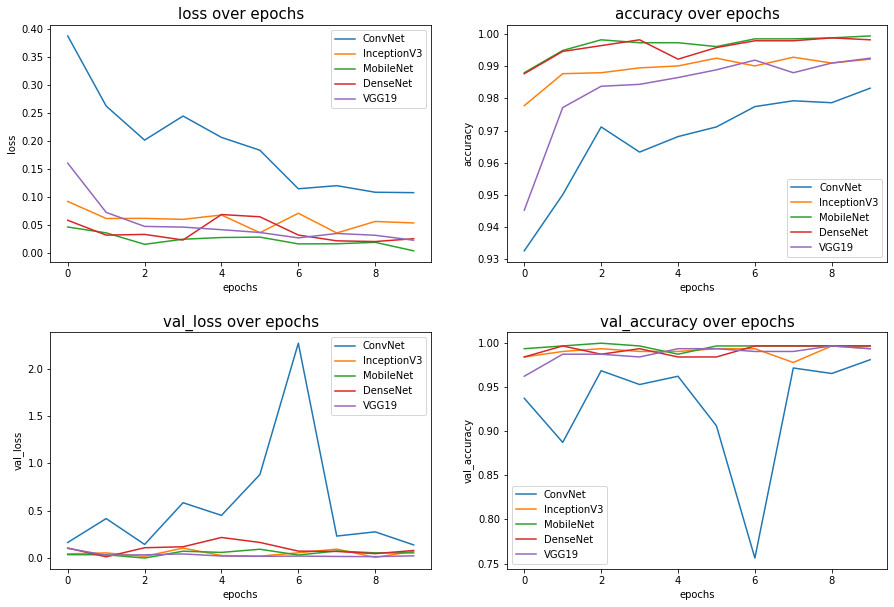

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_histories[0].history:
    index = list(model_histories[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_histories:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric+' over epochs', size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()